<p align="center"><img width="50%" src="https://aimodelsharecontent.s3.amazonaws.com/aimodshare_banner.jpg" /></p>


---




<p align="center"><h1 align="center">Flower Image Classification Model Submission Example<br> 
</h1> 




In [2]:
#install aimodelshare library
%%capture
! pip install aimodelshare --upgrade

## Steps:
Run through your typical ML workflow:
1. Import data, 
2. Preprocess data with preprocessor function and save it
3. Train model and save it

Then connect to competition and submit model
4. Submit model to competition

In [3]:
# Download flower image file (jpg) dataset
import aimodelshare as ai
ai.download_data("public.ecr.aws/y2e2a1d6/flower-competition-data-repository:latest")


Data downloaded successfully.


In [4]:
# Extract filepaths to use to import and preprocess image files...
base_path = 'flower-competition-data/train_images'
categories = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

# Load file paths to fnames list object...
import os

fnames = []

for category in categories:
    flower_folder = os.path.join(base_path, category)
    file_names = os.listdir(flower_folder)
    full_path = [os.path.join(flower_folder, file_name) for file_name in file_names]
    fnames.append(full_path)


## **(1) Preprocessor Function & Setup**

### **Write a Preprocessor Function**


> ###   Preprocessor functions are used to preprocess data into the precise data your model requires to generate predictions.  

*  *Preprocessor functions should always be named "preprocessor".*
*  *You can use any Python library in a preprocessor function, but all libraries should be imported inside your preprocessor function.*  
*  *For image prediction models users should minimally include function inputs for an image filepath and values to reshape the image height and width.*  


In [5]:
# Here is a pre-designed preprocessor, but you could also build your own to prepare the data differently

def preprocessor(data, shape=(128, 128)):
        """
        This function preprocesses reads in images, resizes them to a fixed shape and
        min/max transforms them before converting feature values to float32 numeric values
        required by onnx files.
        
        params:
            data
                list of unprocessed images
                      
        returns:
            X
                numpy array of preprocessed image data
                  
        """
           
        import cv2
        import numpy as np

        "Resize a color image and min/max transform the image"
        img = cv2.imread(data) # Read in image from filepath.
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # cv2 reads in images in order of blue green and red, we reverse the order for ML.
        img = cv2.resize(img, shape) # Change height and width of image.
        img = img / 255.0 # Min-max transform.


        # Resize all the images...
        X = np.array(img)
        X = np.expand_dims(X, axis=0) # Expand dims to add "1" to object shape [1, h, w, channels].
        X = np.array(X, dtype=np.float32) # Final shape for onnx runtime.

        # transpose image to pytorch format
        X = np.transpose(X, (0, 3, 1, 2)) 

        return X

In [6]:
# Import image, load to array of shape height, width, channels, then min/max transform...

# Read in all images from filenames...
preprocessed_image_data = [preprocessor(x) for x in fnames[0] + fnames[1] + fnames[2] + fnames[3] + fnames[4]]

# models require object to be an array rather than a list. (vstack converts above list to array object.)
import numpy as np
X = np.vstack(preprocessed_image_data) # Assigning to X to highlight that this represents feature input data for our model.

In [7]:
X.shape

(2936, 3, 128, 128)

In [8]:
# Create y training label data made up of correctly ordered labels from file folders...
from itertools import repeat

daisy = list(repeat("daisy", 507)) #i.e.: 507 filenames in daisy folder
dandelion = list(repeat("dandelion", 718))
roses = list(repeat("roses", 513))
sunflowers = list(repeat("sunflowers", 559))
tulips = list(repeat("tulips", 639))

# Combine into single list of y labels...
y_labels = daisy + dandelion + roses + sunflowers + tulips

# Check length, same as X above...
len(y_labels)

2936

In [9]:
# get numerical representation of y labels
import pandas as pd
y_labels_num = pd.DataFrame(y_labels)[0].map({'daisy': 4, 'dandelion': 1, # `data_paths` has 'daisy', 'dandelion', 'sunflowers', 'roses', 'tulips'...
                'sunflowers': 2, 'roses': 3, 'tulips': 0}) # ...but `image_paths` has 'tulips' first, and 'daisy' last.

y_labels_num = list(y_labels_num)

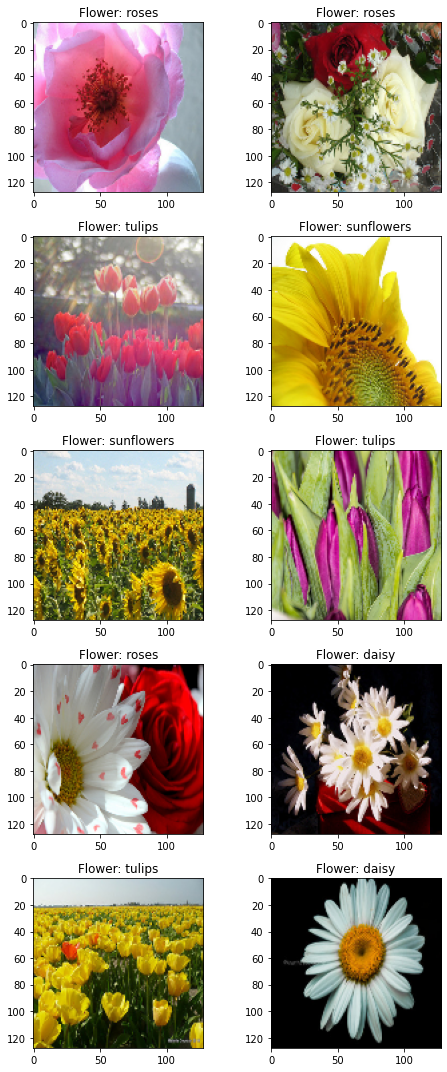

In [10]:
# Visualize images...
%matplotlib inline
from matplotlib import pyplot as plt

fig, ax = plt.subplots(5, 2)
fig.set_size_inches(7, 15)
for i in range(5):
    for j in range (2):
        l = np.random.randint(0, len(y_labels))
        ax[i, j].imshow(np.transpose(X[l], (1, 2, 0))) # need to transpose to show image
        ax[i, j].set_title('Flower: ' + y_labels[l])
        
plt.tight_layout()

In [11]:
# train_test_split resized images...
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_labels_num, 
                                                    stratify = y_labels_num,
                                                    test_size = 0.20, 
                                                    random_state = 1987)

## **(2) Train Model Using Pytorch (or Your Preferred ML Library)**

In [12]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from torchvision.transforms import ToTensor

### **Perpare Data** for Pytorch

In [13]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [14]:
# prepare datasets for pytorch dataloader
tensor_X_train = torch.Tensor(X_train)
tensor_y_train = torch.tensor(y_train, dtype=torch.long) 
train_ds = TensorDataset(tensor_X_train, tensor_y_train) 

tensor_X_test = torch.Tensor(X_test) 
tensor_y_test = torch.tensor(y_test, dtype=torch.long) 
test_ds = TensorDataset(tensor_X_test, tensor_y_test)

In [15]:
# set up dataloaders
batch_size = 50
train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [16]:
for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([50, 3, 128, 128])
Shape of y: torch.Size([50]) torch.int64


### Pytorch **Neural Network**

In [17]:
# Define pytorch model

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(128*128*3, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 5)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=49152, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=5, bias=True)
  )
)


In [18]:
# set up loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [19]:
# define training function

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [20]:
# define testing function

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [21]:
epochs = 2
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 1.607722  [    0/ 2348]
Test Error: 
 Accuracy: 29.1%, Avg loss: 1.579980 

Epoch 2
-------------------------------
loss: 1.575774  [    0/ 2348]
Test Error: 
 Accuracy: 33.3%, Avg loss: 1.554854 

Done!


## **(3) Save Preprocessor**
### Saves preprocessor function to "preprocessor.zip" file

In [22]:
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"") 

Your preprocessor is now saved to 'preprocessor.zip'


In [23]:
#  Now let's import and test the preprocessor function to see if it is working...

prep=ai.import_preprocessor("preprocessor.zip")

prep("flower-competition-data/train_images/daisy/10140303196_b88d3d6cec.jpg").shape

(1, 3, 128, 128)

## **(4) Save Pytorch Model to Onnx File Format**


In [24]:
# Save pytorch model to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

example_input = torch.randn(1, 3, 128, 128, requires_grad=True)

onnx_model = model_to_onnx(model, framework='pytorch',
                           model_input=example_input,
                          transfer_learning=False,
                          deep_learning=True)

with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [25]:
# Create one hot encoded data from list of y_train category labels
#   to allow ModelPlayground.deploy() to extract correct labels for predictions 

import pandas as pd
y_train = pd.get_dummies(y_train)
y_train.columns = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

#ensure column names are correct in one hot encoded target for correct label extraction
list(y_train.columns)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [46]:
#Instantiate Competition 
#--Note: If you start a new session, the first argument should be the Model Playground url in quotes. 
#--e.g.- mycompetition= ai.Competition("https://2121212.execute-api.us-east-1.amazonaws.com/prod/m")
#See Model Playground "Compete" tab for example model submission code.
playground_id_url="https://7aqq6uo8tg.execute-api.us-east-2.amazonaws.com/prod/m"

mycompetition= ai.Competition(playground_id_url)


Submit Models

In [57]:
# Set credentials 
import aimodelshare as ai
from aimodelshare.aws import set_credentials

set_credentials(type="submit_model")

AI Modelshare Username:··········
AI Modelshare Password:··········
AI Model Share login credentials set successfully.


In [ ]:
#Submit Model 1: 

#-- Generate predicted y values (Model 1)
#Note: returns the predicted column index location for classification models
prediction_column_index=model(tensor_X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'][i] for i in prediction_column_index]

# Submit Model 1 to Competition Leaderboard
mycompetition.submit_model(model_filepath = "model.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

In [51]:
# Create model 2 

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(128*128*3, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 5)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model2 = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=49152, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=5, bias=True)
  )
)


In [52]:
# set up loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model2.parameters(), lr=1e-3)

In [53]:
# train model
epochs = 3
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model2, loss_fn, optimizer)
    test(test_dataloader, model2, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 1.602879  [    0/ 2348]
Test Error: 
 Accuracy: 27.9%, Avg loss: 1.601894 

Epoch 2
-------------------------------
loss: 1.598177  [    0/ 2348]
Test Error: 
 Accuracy: 28.2%, Avg loss: 1.596615 

Epoch 3
-------------------------------
loss: 1.592703  [    0/ 2348]
Test Error: 
 Accuracy: 28.7%, Avg loss: 1.591413 

Done!


In [43]:
# Save Model 2 to .onnx file

example_input = torch.randn(1, 3, 128, 128, requires_grad=True)

onnx_model2 = model_to_onnx(model2, framework='pytorch',
                           model_input=example_input,
                          transfer_learning=False,
                          deep_learning=True)

with open("model2.onnx", "wb") as f:
    f.write(onnx_model2.SerializeToString())

In [ ]:
#Submit Model 2: 

#-- Generate predicted y values (Model 2)
#Note: returns the predicted column index location for classification models
prediction_column_index=model2(tensor_X_test).argmax(axis=1)

# extract correct prediction labels
prediction_labels = [['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'][i] for i in prediction_column_index]

# Submit Model 2 to Competition Leaderboard
mycompetition.submit_model(model_filepath = "model2.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

Get Leaderboard

In [48]:
data = mycompetition.get_leaderboard()
mycompetition.stylize_leaderboard(data)

ValueError: ignored

Compare Models

In [38]:
# Compare two or more models (Experimental, Git-like Diffs for Model Architectures)
data=mycompetition.compare_models([1,2], verbose=1)
mycompetition.stylize_compare(data, naming_convention='pytorch')

,Model_1_Layer,Model_1_Shape,Model_1_Params,Model_2_Layer,Model_2_Shape,Model_2_Params
0,Flatten,[],0.000000,Flatten,[],0
1,Linear,"[[512, 49152], [512]]",25166336.000000,Linear,"[[512, 49152], [512]]",25166336
2,Linear,"[[512, 512], [512]]",262656.000000,Linear,"[[512, 512], [512]]",262656
3,Linear,"[[5, 512], [5]]",2565.000000,Linear,"[[256, 512], [256]]",131328
4,None,None,nan,Linear,"[[5, 256], [5]]",1285


#### Check structure of y test data 
(This helps users understand how to submit predicted values to leaderboard)

In [39]:
mycompetition.inspect_y_test()

{'ytest_example': ['roses', 'roses', 'dandelion', 'roses', 'roses'],
 'y_length': 588,
 'class_labels': ['daisy', 'tulips', 'dandelion', 'roses', 'sunflowers'],
 'class_balance': {'roses': 112,
  'dandelion': 144,
  'tulips': 101,
  'sunflowers': 103,
  'daisy': 128},
 'label_dtypes': {"<class 'str'>": 588}}